# GTI + STAC (geo)parquet demo

The goal is to use rustac to query STAC records, write them to a STAC (geo)parquet file, then use GDAL's GTI driver to open the data with xarray.

In [43]:
import subprocess
import uuid
from datetime import datetime
from pathlib import Path
from tempfile import TemporaryDirectory

import rasterio
import rioxarray
import rustac
import xarray as xr
from rasterio.warp import transform_bounds

START_DATE = datetime(2025, 6, 1)
END_DATE = datetime(2025, 6, 5)
DST_CRS = "epsg:5070"  # a good one for the US
DST_BBOX = (-150000, 2500000, 600000, 3000000)
XY_CHUNK_SIZE = 2048
BBOX_4326 = transform_bounds(DST_CRS, "epsg:4326", *DST_BBOX)

tempdir = Path(TemporaryDirectory().name)

Use `rustac` to write some Sentinel-2 STAC items to a geoparquet file. The GTI driver will use the CRS from stac-geoparquet file (`epsg:4326`) for our array later so if we can just reproject it and use the reprojected geoparquet for the data read step.

In [44]:
stac_geoparquet = tempdir / "items.parquet"
stac_geoparquet_projected = tempdir / "items_projected.parquet"
print(f"writing STAC items to {stac_geoparquet}")
if not stac_geoparquet.exists():
    await rustac.search_to(
        str(stac_geoparquet),
        "https://earth-search.aws.element84.com/v1",
        collections="sentinel-2-c1-l2a",
        datetime=f"{START_DATE.strftime("%Y-%m-%dT00:00:00Z")}/{END_DATE.strftime("%Y-%m-%dT23:59:59Z")}",
        bbox=BBOX_4326,
        limit=100,
        compression=None,
    )

    subprocess.run(
        ["ogr2ogr", "-t_srs", DST_CRS, stac_geoparquet_projected, stac_geoparquet]
    )

writing STAC items to /tmp/tmpja0o5cce/items.parquet


## Load into xarray using rioxarray + GTI driver

This works lazily, which is great, but it is quirky:
1. The GTI driver does not know what to do when there are multiple STAC assets. Ideally it could just load them all as a multi-band dataset, but instead it will fail with an error like `could not find field: location`. To get around this you can specify `LOCATION_FIELD=assets.{asset}.href` but it will just load the asset that you reference and not the others.
2. When you try to lazily open multiple arrays that point to the same file handle (the stac-geoparquet file in our case), something gets cached and the all-important `LOCATION_FIELD` opener option will get swamped. You will wind up with a 3-D array but each band will be referencing the last band that you loaded. My solution to avoid this is to symlink the parquet file once per band, so the file-based cache does not mess up the bands in our final array.
3. There are some other nice features exposed by the [GTI Open options](https://gdal.org/en/stable/drivers/raster/gti.html#open-options) like `SORT_FIELD` and `SORT_FIELD_ASC` for sorting the records during mosaic operations.

In [49]:
arrays = []

for band in ["red", "green", "blue"]:
    band_parquet = tempdir / f"{uuid.uuid4()}.parquet"
    band_parquet.symlink_to(stac_geoparquet_projected)
    arr = rioxarray.open_rasterio(
        band_parquet,
        driver="GTI",
        LOCATION_FIELD=f"assets.{band}.href",
        RESAMPLING="nearest",
        SORT_FIELD_ASC="eo:cloud_cover",
        chunks={"x": 512, "y": 512},
    ).squeeze().assign_coords(band=band).astype("uint16")

    arrays.append(arr)

da = xr.concat(arrays, dim="band")
da

<xarray.DataArray (band: 3, y: 64381, x: 95230)> Size: 37GB
dask.array<concatenate, shape=(3, 64381, 95230), dtype=uint16, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) <U5 60B 'red' 'green' 'blue'
  * y            (y) float64 515kB 3.09e+06 3.09e+06 ... 2.446e+06 2.446e+06
  * x            (x) float64 762kB -2.36e+05 -2.36e+05 ... 7.166e+05 7.167e+05
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:    0
    scale_factor:  1.0
    add_offset:    0.0

Grab a slice from the middle of the large array.

In [50]:
test = da.isel(x=slice(30000, 31000), y=slice(30000, 31000))
test

<xarray.DataArray (band: 3, y: 1000, x: 1000)> Size: 6MB
dask.array<getitem, shape=(3, 1000, 1000), dtype=uint16, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) <U5 60B 'red' 'green' 'blue'
  * y            (y) float64 8kB 2.79e+06 2.79e+06 ... 2.78e+06 2.78e+06
  * x            (x) float64 8kB 6.413e+04 6.414e+04 ... 7.412e+04 7.413e+04
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:    0
    scale_factor:  1.0
    add_offset:    0.0

Render an image, just fetching the bytes required to fill this slice with reprojected data.

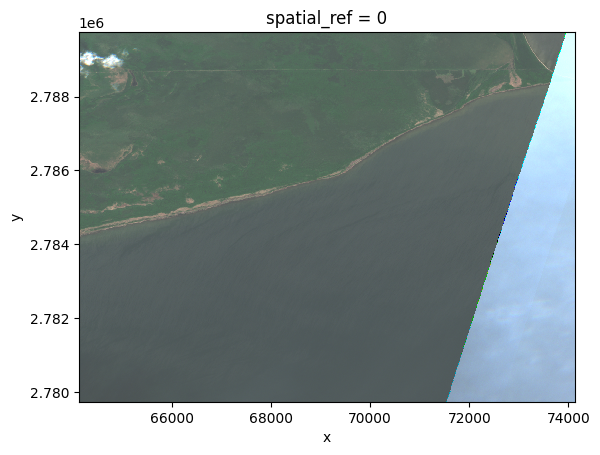

In [53]:
test.plot.imshow(rgb="band", vmin=0, vmax=4000)